# Analyze Maxar Image Availability

Takes in a CSVs of:
- All polygon features
- All Maxar images available for those polygons
- Filtered mage availability per polygon
- Filtered image availability per project (aggregated)
- Low coverage polygons

Analysis:

Outline:

Step 1: Load already computed CSVs for:
 - poly_img_avail_base_df
 - poly_img_avail_ev_df
 - project_img_avail_base_df
 - project_img_avail_ev_df
 - poly_gdf
 - maxar_gdf

Step 2: Merge plantstart years (from poly_gdf) into polygon-level image availability

Step 3: Calculate planting year distributions (by polygon)

Step 4: Assemble baseline & EV coverage from project-level files

Step 5: Calculate % area covered by baseline and by EV imagery

Step 6: Calculate % area with coverage at both points


In [1]:
import pandas as pd
import geopandas as gpd
import sys
sys.path.append('../src/')
import image_coverage as img_cover
import analyze_img_coverage as analyze
from datetime import datetime, timedelta

## Set file paths

In [2]:
# Set input file paths
# Polygon metadata & geometries from TM API
feats = '../data/tf_cohort1/tm_api_cohort1_2025-04-02.csv' 

# Metadata for Maxar images corresponding to polygons
maxar_md = '../data/tf_cohort1/imagery_availability/comb_img_availability_cohort1_2025-04-02.csv' 

# List of approved projects (with country codes)
approved_projects = '../projects_all_approved_202502211226.csv'

# Image availability
# Baseline
poly_img_avail_base = '../data/tf_cohort1/results/baseline/polygon_imagery_coverage_cohort1_2025-04-02.csv'
low_cov_poly_base = '../data/tf_cohort1/results/baseline/low_coverage_polygons_cohort1_2025-04-02.csv'
proj_img_avail_base = '../data/tf_cohort1/results/baseline/project_imagery_coverage_cohort1_2025-04-02.csv'

# Early Verification
poly_img_avail_ev = '../data/tf_cohort1/results/year_2/polygon_imagery_coverage_cohort1_2025-04-02.csv'
low_cov_poly_ev = '../data/tf_cohort1/results/year_2/low_coverage_polygons_cohort1_2025-04-02.csv'
proj_img_avail_ev = '../data/tf_cohort1/results/year_2/project_imagery_coverage_cohort1_2025-04-02.csv'

## Read in files|

In [3]:
# Polygon feature data
poly_df = pd.read_csv(feats)

# Maxar data
maxar_df = pd.read_csv(maxar_md)

# Image availability
# Baseline
poly_img_avail_base_df = pd.read_csv(poly_img_avail_base)
low_cov_poly_base_df = pd.read_csv(low_cov_poly_base)
proj_img_avail_base_df = pd.read_csv(proj_img_avail_base)

# Early Verification
poly_img_avail_ev_df = pd.read_csv(poly_img_avail_ev)
low_cov_poly_ev_df = pd.read_csv(low_cov_poly_ev)
proj_img_avail_ev_df = pd.read_csv(proj_img_avail_ev)

## Preprocess polygon and maxar image data

In [4]:
poly_gdf = img_cover.preprocess_polygons(poly_df, debug=True)
maxar_gdf = img_cover.preprocess_images(maxar_df, debug=True)

Processing polygon data...
Cleaning geometries...

🧾 Geometry Cleaning Summary:
  ➤ Total geometries processed: 13537
  ➤ Invalid geometries:         0
  ➤ Repaired with buffer(0):    0
  ➤ Dropped:                    0
  ✅ Final valid polygons:       13537

Processing Maxar image data...
There are 175641 images for 12168 polygons in 78 projects in this dataset.


## Merge 'plantstart' and poly_geom into image availability data

In [5]:
# Merge plantstart and poly_geom into baseline and EV image availability
poly_img_avail_base_df = poly_img_avail_base_df.merge(poly_gdf[['poly_id', 'plantstart', 'poly_geom']], on='poly_id', how='left')
poly_img_avail_ev_df = poly_img_avail_ev_df.merge(poly_gdf[['poly_id', 'plantstart', 'poly_geom']], on='poly_id', how='left')

In [6]:
poly_img_avail_base_df.head(2)

,poly_id,project_id,best_image,num_images,poly_area_ha,overlap_area_ha,percent_img_cover,plantstart,poly_geom
0,a40e322b-42ff-4008-8407-e611b170a39c,389aad5b-6577-4cea-bf9f-446dcfd94966,NaN,0,0.231599,0.0,0.0,2022-01-08,"POLYGON ((31.39719 1.51653, 31.3972 1.51652, 3..."
1,9dcccf42-cd63-471b-a251-abd1009fb819,389aad5b-6577-4cea-bf9f-446dcfd94966,NaN,0,0.467551,0.0,0.0,2022-01-08,"POLYGON ((31.39611 1.51079, 31.39611 1.51075, ..."


## Calculate planting year stats by project

In [7]:
# Extract year from plantstart
poly_img_avail_base_df['plant_year'] = poly_img_avail_base_df['plantstart'].dt.year

# Group by project and calculate planting year distinctions
planting_stats = poly_img_avail_base_df.groupby('project_id').agg(
    num_poly=('poly_id', 'count'),
    pct_poly_plant_2022=('plant_year', lambda x: (x == 2022).sum() / len(x) * 100),
    pct_poly_plant_2023=('plant_year', lambda x: (x == 2023).sum() / len(x) * 100),
    pct_poly_plant_2024=('plant_year', lambda x: (x == 2024).sum() / len(x) * 100),
).reset_index()

## Calculate % polygons with imagery at baseline & early verification

In [8]:
# Count % of polygons with at least one baseline image
poly_img_avail_base_df['has_base_img'] = poly_img_avail_base_df['num_images'] > 0
base_img_stats = poly_img_avail_base_df.groupby('project_id')['has_base_img'].mean().reset_index()
base_img_stats = base_img_stats.rename(columns={'has_base_img': 'pct_poly_wi_base_img'})
base_img_stats['pct_poly_wi_base_img'] *= 100

# Count # of polygons with at least one early verification image
poly_img_avail_ev_df['has_ev_img'] = poly_img_avail_ev_df['num_images'] > 0
ev_img_stats = poly_img_avail_ev_df.groupby('project_id')['has_ev_img'].mean().reset_index()
ev_img_stats = ev_img_stats.rename(columns={'has_ev_img': 'pct_poly_wi_ev_img'})
ev_img_stats['pct_poly_wi_ev_img'] *= 100

## Calculate % of polygons with high image coverage (> 70%) at both time points

In [9]:
# Filter to only needed columns
base_cov = poly_img_avail_base_df[['poly_id', 'project_id', 'percent_img_cover']].copy()
ev_cov = poly_img_avail_ev_df[['poly_id', 'percent_img_cover']].copy()

# Rename for clarity before merge
base_cov = base_cov.rename(columns={'percent_img_cover': 'base_pct_img_cover'})
ev_cov = ev_cov.rename(columns={'percent_img_cover': 'ev_pct_img_cover'})

# Merge coverage values by poly_id
joined_cov = base_cov.merge(ev_cov, on='poly_id', how='inner')

# Define a coverage threshold for "high coverage"
cover_thresh = 70

# Check if both timepoints have > 70% coverage
joined_cov['high_cov_both'] = (
    (joined_cov['base_pct_img_cover'] >= cover_thresh) &
    (joined_cov['ev_pct_img_cover'] >= cover_thresh)
)

# Group by project and compute % of polygons with high coverage at both
high_cov_stats = joined_cov.groupby('project_id')['high_cov_both'].mean().reset_index()
high_cov_stats['pct_poly_wi_high_cov_both'] = high_cov_stats['high_cov_both'] * 100
high_cov_stats = high_cov_stats.drop(columns='high_cov_both')

## Assemble summary table at project level

In [19]:
# Start from planting_stats (project_id, number of polygons, and % that started planting each year)
project_summary_df = planting_stats.copy()

# Merge in baseline image availability
project_summary_df = project_summary_df.merge(base_img_stats, on='project_id', how='left')

# Merge in early verification image availability
project_summary_df = project_summary_df.merge(ev_img_stats, on='project_id', how='left')

# Merge in % polygons with high coverage at both time points
project_summary_df = project_summary_df.merge(high_cov_stats, on='project_id', how='left')

project_summary_df = project_summary_df.sort_values(by='pct_poly_wi_high_cov_both', ascending=False)
project_summary_df.sort_values('pct_poly_plant_2022', ascending=False).head(20)

,project_id,num_poly,pct_poly_plant_2022,pct_poly_plant_2023,pct_poly_plant_2024,pct_poly_wi_base_img,pct_poly_wi_ev_img,pct_poly_wi_high_cov_both
13,33274073-8a4e-4eca-8b97-0e8da3833105,8,100.000000,0.000000,0.0,100.000000,100.000000,100.000000
64,cf106374-3dd4-401d-80ba-25b70247381a,1,100.000000,0.000000,0.0,100.000000,100.000000,100.000000
54,a8940698-ff28-456c-b8cd-f7289e612913,290,100.000000,0.000000,0.0,99.310345,97.931034,93.793103
19,3a860077-df4c-4e95-8fec-41520c551243,13,100.000000,0.000000,0.0,100.000000,100.000000,92.307692
38,6af68b37-d2bc-4020-aaab-77a42cc25fd4,186,100.000000,0.000000,0.0,52.688172,99.462366,51.075269
0,01918b25-6544-4027-82aa-6703c7c04784,3,100.000000,0.000000,0.0,100.000000,100.000000,66.666667
62,caf78b0a-d80a-482e-9c62-842302109a90,30,100.000000,0.000000,0.0,100.000000,6.666667,0.000000
34,5fb3f47f-c209-4752-adc6-dea2c0de02de,7,100.000000,0.000000,0.0,0.000000,100.000000,0.000000
7,246a0906-7e03-4b57-bf71-b697b333509f,1,100.000000,0.000000,0.0,0.000000,100.000000,0.000000
5,1e207d56-d0ed-4b4f-b1d9-94aa8aafb71f,9,100.000000,0.000000,0.0,0.000000,66.666667,0.000000


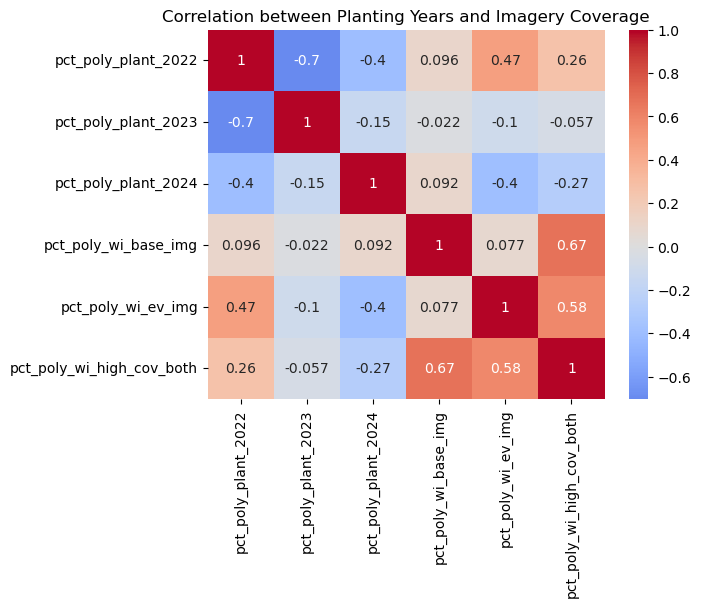

In [21]:
# Do earlier planting projects tend to have higher imagery coverage?
import seaborn as sns
import matplotlib.pyplot as plt

cos_to_check = [
    'pct_poly_plant_2022',
    'pct_poly_plant_2023',
    'pct_poly_plant_2024',
    'pct_poly_wi_base_img',
    'pct_poly_wi_ev_img',
    'pct_poly_wi_high_cov_both'
]

sns.heatmap(project_summary_df[cos_to_check].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Planting Years and Imagery Coverage')
plt.show()

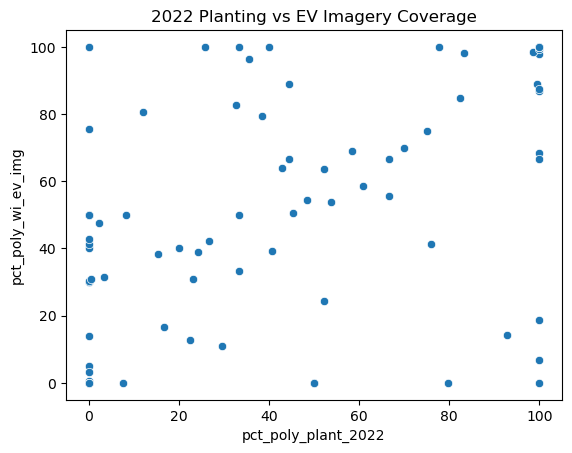

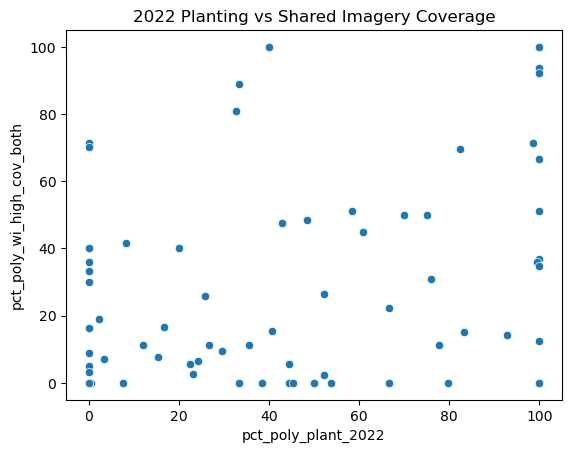

In [23]:
sns.scatterplot(data=project_summary_df, x='pct_poly_plant_2022', y='pct_poly_wi_ev_img')
plt.title("2022 Planting vs EV Imagery Coverage")
plt.show()

sns.scatterplot(data=project_summary_df, x='pct_poly_plant_2022', y='pct_poly_wi_high_cov_both')
plt.title("2022 Planting vs Shared Imagery Coverage")
plt.show()

In [29]:
import statsmodels.api as sm

x = project_summary_df['pct_poly_plant_2022']
y = project_summary_df['pct_poly_wi_ev_img']
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     pct_poly_wi_ev_img   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     22.12
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           1.09e-05
Time:                        10:02:18   Log-Likelihood:                -386.18
No. Observations:                  80   AIC:                             776.4
Df Residuals:                      78   BIC:                             781.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  34.1817    

In [32]:
# Group projects by dominant planting year
def dominant_planting_year(row):
    return max(('2022', row['pct_poly_plant_2022']), 
               ('2023', row['pct_poly_plant_2023']),
               ('2024', row['pct_poly_plant_2024']), 
               key=lambda x: x[1])[0]

project_summary_df['dominant_year'] = project_summary_df.apply(dominant_planting_year, axis=1)
project_summary_df.head()

,project_id,num_poly,pct_poly_plant_2022,pct_poly_plant_2023,pct_poly_plant_2024,pct_poly_wi_base_img,pct_poly_wi_ev_img,pct_poly_wi_high_cov_both,dominant_year
13,33274073-8a4e-4eca-8b97-0e8da3833105,8,100.0,0.0,0.0,100.000000,100.000000,100.000000,2022
9,292bbbda-ec32-40e2-a127-3670a052423d,5,40.0,60.0,0.0,100.000000,100.000000,100.000000,2023
64,cf106374-3dd4-401d-80ba-25b70247381a,1,100.0,0.0,0.0,100.000000,100.000000,100.000000,2022
54,a8940698-ff28-456c-b8cd-f7289e612913,290,100.0,0.0,0.0,99.310345,97.931034,93.793103,2022
19,3a860077-df4c-4e95-8fec-41520c551243,13,100.0,0.0,0.0,100.000000,100.000000,92.307692,2022


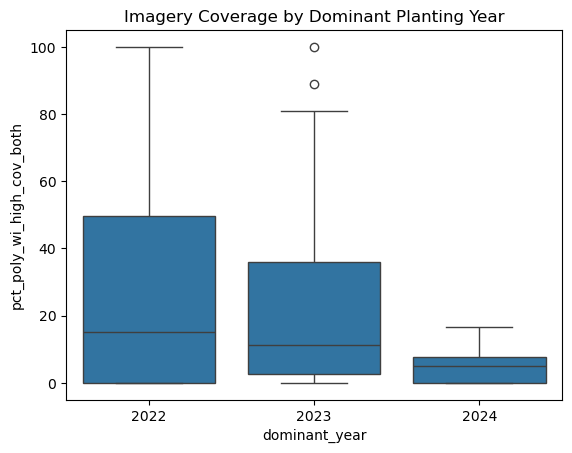

In [ ]:
sns.boxplot(data=project_summary_df, x='dominant_year', y='pct_poly_wi_high_cov_both')
plt.title('Imagery Coverage by Dominant Planting Year')
plt.show()

In [62]:
project_summary_df.groupby('dominant_year')['pct_poly_wi_high_cov_both'].mean()

dominant_year
2022    28.272554
2023    23.743013
2024     5.847405
Name: pct_poly_wi_high_cov_both, dtype: float64

In [60]:
project_summary_df.head()

,project_id,num_poly,pct_poly_plant_2022,pct_poly_plant_2023,pct_poly_plant_2024,pct_poly_wi_base_img,pct_poly_wi_ev_img,pct_poly_wi_high_cov_both,dominant_year,high_coverage
13,33274073-8a4e-4eca-8b97-0e8da3833105,8,100.0,0.0,0.0,100.000000,100.000000,100.000000,2022,True
9,292bbbda-ec32-40e2-a127-3670a052423d,5,40.0,60.0,0.0,100.000000,100.000000,100.000000,2023,True
64,cf106374-3dd4-401d-80ba-25b70247381a,1,100.0,0.0,0.0,100.000000,100.000000,100.000000,2022,True
54,a8940698-ff28-456c-b8cd-f7289e612913,290,100.0,0.0,0.0,99.310345,97.931034,93.793103,2022,True
19,3a860077-df4c-4e95-8fec-41520c551243,13,100.0,0.0,0.0,100.000000,100.000000,92.307692,2022,True


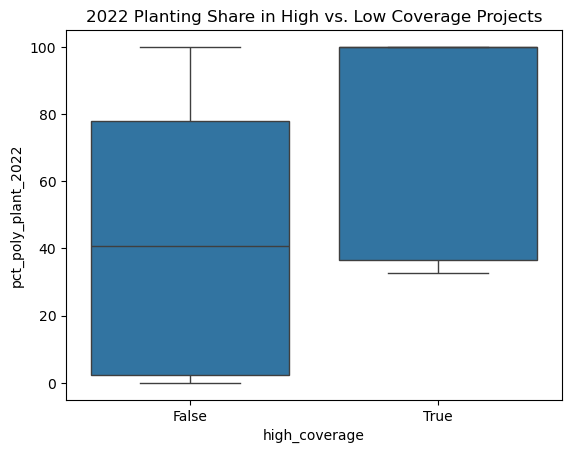

In [42]:
# Flag High/Low Coverage Projects
project_summary_df['high_coverage'] = project_summary_df['pct_poly_wi_high_cov_both'] >= 75
sns.boxplot(data=project_summary_df, x='high_coverage', y='pct_poly_plant_2022')
plt.title("2022 Planting Share in High vs. Low Coverage Projects")
plt.show()

In [64]:
project_summary_df.groupby('dominant_year')['pct_poly_wi_ev_img'].mean()

dominant_year
2022    59.814311
2023    51.209367
2024    20.572679
Name: pct_poly_wi_ev_img, dtype: float64

In [63]:
project_summary_df.groupby('dominant_year')[['pct_poly_wi_ev_img', 'pct_poly_wi_high_cov_both']].agg(['mean', 'median', 'std'])

pct_poly_wi_ev_img                        \
                            mean     median        std   
dominant_year                                            
2022                   59.814311  66.666667  36.237312   
2023                   51.209367  50.000000  31.200292   
2024                   20.572679  16.666667  19.374094   

              pct_poly_wi_high_cov_both                        
                                   mean     median        std  
dominant_year                                                  
2022                          28.272554  15.242464  31.743420  
2023                          23.743013  11.111111  28.944865  
2024                           5.847405   4.878049   6.888106

## Calculate % of project area with imagery at baseline and early verification

### Functions

In [ ]:
def extract_img_id(title):
    """
    Extracts the Maxar image ID from the Maxar image title 
    """
    if isinstance(title, str) and title.startswith("Maxar"):
        return title.split()[-1]
    return None

### Create a dataframe with best image id and geometry for all polygons for baseline

In [ ]:
# Add an 'img_id' column to the dataframes of polygon-level best image availability at baseline & EV
poly_img_avail_base_df['img_id_base'] = poly_img_avail_base_df['best_image'].apply(extract_img_id)
poly_img_avail_ev_df['img_id_ev'] = poly_img_avail_ev_df['best_image'].apply(extract_img_id)

In [ ]:
# Create a dataframe with each unique img_id (and it associated geometry) from maxar_gdf
img_geom_lookup = maxar_gdf[['img_id', 'img_geom']].drop_duplicates()

In [ ]:
# Merge the image's footprint geometry (img_geom) to each relevent row in poly_img_avail_base/ev_df

# Baseline
poly_img_avail_base_df = poly_img_avail_base_df.merge(
    img_geom_lookup.rename(columns={'img_id': 'img_id_base', 'img_geom': 'img_geom_base'}),
    on='img_id_base', how='left'
)

# Early verification
poly_img_avail_ev_df = poly_img_avail_ev_df.merge(
    img_geom_lookup.rename(columns={'img_id': 'img_id_ev', 'img_geom': 'img_geom_ev'}),
    on='img_id_ev', how='left'
)

In [ ]:
## Build a dataframe with all relevent info for the best image at baseline & EV for each polygon ##

# Step 1: Select relevent columns from baseline dataframe and rename
base_cols = poly_img_avail_base_df[[
    'poly_id', 'project_id', 'plantstart', 'poly_geom',
    'best_image', 'img_id_base', 'percent_img_cover', 'img_geom_base'
]].rename(columns={
    'best_image': 'best_image_base',
    'percent_img_cover': 'percent_img_cover_base',
})

# Step 2: Select relevent columns from early verification dataframe and rename
ev_cols = poly_img_avail_ev_df[[
    'poly_id', 'best_image', 'img_id_ev', 'percent_img_cover', 'img_geom_ev'
]].rename(columns={
    'best_image': 'best_image_ev',
    'percent_img_cover': 'percent_img_cover_ev',
})

# Step 3: Merge baseline and EV info on poly_id (inner)
#  This creates a DF with ONLY polygons with a best image at both baseline & EV
poly_double_cov_df = base_cols.merge(ev_cols, on='poly_id', how='inner')

print(f"Length of poly_double_cov_df before filtering: {len(poly_double_cov_df)}")

# Step 4: Filter to only include polygons with a best image at both baseline & EV
poly_double_cov_df = poly_double_cov_df.dropna(subset=['best_image_base', 'best_image_ev'])
print(f"Length of poly_double_cov_df after filtering: {len(poly_double_cov_df)}")


In [ ]:
# #53 - very small overlap
# #117
# test_row = poly_double_cov_df.iloc[117]
# print("Test row:")
# print(test_row)
# print()

# # Extract geometries
# poly_geom = test_row['poly_geom']
# img_geom_base = test_row['img_geom_base']
# img_geom_ev = test_row['img_geom_ev']

# # Get UTM CRS from polygon centroid
# centroid = poly_geom.centroid
# utm_crs = img_cover.get_utm_crs(centroid.x, centroid.y)
# print(f"Using UTM CRS: {utm_crs}")

# # Reproject all geometries to UTM
# poly_proj = gpd.GeoSeries([poly_geom], crs="EPSG:4326").to_crs(utm_crs).iloc[0]
# base_proj = gpd.GeoSeries([img_geom_base], crs="EPSG:4326").to_crs(utm_crs).iloc[0]
# ev_proj = gpd.GeoSeries([img_geom_ev], crs="EPSG:4326").to_crs(utm_crs).iloc[0]

# # Calculate polygon area (ha)
# poly_area_ha = poly_proj.area / 10_000
# print(f"Polygon area: {poly_area_ha:.2f} ha")

# # Get overlaps
# overlap_base = poly_proj.intersection(base_proj)
# overlap_ev = poly_proj.intersection(ev_proj)

# # Get intersection of overlaps
# overlap_both = overlap_base.intersection(overlap_ev)

# # Compute shared coverage area (ha)
# overlap_area_ha = overlap_both.area / 10_000
# percent_overlap = (overlap_area_ha / poly_area_ha) * 100

# # Print results
# print()
# print(f"Overlap with both images: {overlap_area_ha:.6f} ha")
# print(f"Percent polygon area with shared image coverage: {percent_overlap:.2f}%")

In [ ]:
def compute_shared_image_overlap(row, debug=False):
    """
    Given a row with polygon and baseline/EV image footprints, compute shared area of image coverage
    (in hectares and as a % of the polygon's area)
    """
    # Extract geometries
    poly_geom = row['poly_geom']
    base_img = row['img_geom_base']
    ev_geom = row['img_geom_ev']

    # Use centroid to determine UTM zone
    centroid = poly_geom.centroid
    utm_crs = img_cover.get_utm_crs(centroid.x, centroid.y)

    # Reproject all geometries to UTM
    poly_proj = gpd.GeoSeries([poly_geom], crs="EPSG:4326").to_crs(utm_crs).iloc[0]
    base_proj = gpd.GeoSeries([img_geom_base], crs="EPSG:4326").to_crs(utm_crs).iloc[0]
    ev_proj = gpd.GeoSeries([img_geom_ev], crs="EPSG:4326").to_crs(utm_crs).iloc[0]

    # Compute area of polygon
    poly_area_ha = poly_proj.area / 10_000

    # Calculate overlap between polygon and imagery at baseline & EV
    overlap_base = poly_proj.intersection(base_proj)
    overlap_ev = poly_proj.intersection(ev_proj)

    # Get intersection of overlaps
    shared_overlap = overlap_base.intersection(overlap_ev)

    # Calculate area of shared overlap & % of polygon area
    shared_overlap_area_ha = shared_overlap.area / 10_000
    shared_pct_cover = (shared_overlap_area_ha / poly_area_ha) * 100 if poly_area_ha > 0 else 0

    if debug:
        print(f"Polygon area (ha): {poly_area_ha:.2f}")
        print(f"Shared overlap area (ha): {shared_overlap_area_ha:.4f}")
        print(f"Shared coverage (%): {shared_pct_cover:.2f}")

    return pd.Series({
        'poly_area_ha_actual': poly_area_ha,
        'shared_overlap_ha': shared_overlap_area_ha,
        'shared_pct_img_cover': shared_pct_cover
    })

In [ ]:
# Apply the compute_shared_image_overlap() function to all rows of the poly_double_cov_df dataframe
shared_cov_results = poly_double_cov_df.apply(
    lambda row: compute_shared_image_overlap(row, debug=False), axis=1
)

# Merge the results into the original dataframe (of all polygons with images at both baseline & EV)
poly_double_cov_df = pd.concat([poly_double_cov_df, shared_cov_results], axis=1)

In [ ]:
poly_double_cov_df.head(3)

In [ ]:
poly_double_cov_df['shared_pct_img_cover'].describe()

In [ ]:
len(poly_double_cov_df[poly_double_cov_df['shared_pct_img_cover'] == 0])

In [ ]:
len(poly_double_cov_df[(poly_double_cov_df['percent_img_cover_base'] == 100) &
                   (poly_double_cov_df['percent_img_cover_ev'] == 100)])

In [ ]:
poly_double_cov_df[['percent_img_cover_base', 'percent_img_cover_ev', 'shared_pct_img_cover']].sample(5)

In [ ]:
test_row = poly_double_cov_df.iloc[0]
test_row

In [ ]:
results = compute_shared_image_overlap(test_row)
results